In [1]:
import pandas as pd
import zipfile
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to the gzip file in your Google Drive
PATH_TO_NOTEEVENTS_GZ = '/content/drive/My Drive/NOTEEVENTS.csv.gz'  # Edit to the correct path
PATH_TO_NOTEEVENTS_CSV = '/content/NOTEEVENTS.csv'  # Path to extract the CSV file to

# Verify file exists
import os
if not os.path.exists(PATH_TO_NOTEEVENTS_GZ):
    raise FileNotFoundError(f"File not found: {PATH_TO_NOTEEVENTS_GZ}. Please ensure the file exists and the path is correct.")

# Read the gzipped CSV file directly using pandas
df_noteevents = pd.read_csv(PATH_TO_NOTEEVENTS_GZ, compression='gzip')

<ipython-input-3-e0b922c73f55>:11: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_noteevents = pd.read_csv(PATH_TO_NOTEEVENTS_GZ, compression='gzip')


In [4]:
df_noteevents.info()
df_noteevents.iloc[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB


,0
ROW_ID,174
SUBJECT_ID,22532
HADM_ID,167853.0
CHARTDATE,2151-08-04
CHARTTIME,NaN
STORETIME,NaN
CATEGORY,Discharge summary
DESCRIPTION,Report
CGID,NaN
ISERROR,NaN


In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

!gcloud projects list

from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(project='clinical-entity-extraction')

# List all tables in the dataset.
dataset_ref = client.get_dataset('physionet-data.mimiciii_clinical')
tables = list(client.list_tables(dataset_ref))

print("Tables:")
for table in tables:
    table_ref = dataset_ref.table(table.table_id)
    table = client.get_table(table_ref)
    print(f"  {table.table_id}: {table.num_rows} rows")

Authenticated
PROJECT_ID                  NAME                        PROJECT_NUMBER
clinical-entity-extraction  clinical-entity-extraction  321960627270
dulcet-elevator-257302      Personal API project        731274068268
hackhelper-cb7fe            HackOrganized               284511353607
physionet-data-449900       physionet-data              398801384102
ricehack-ac1a8              riceHack                    1054752105505
safesound-e5d17             safesound                   14104572424
stayalert-8b5b2             StayAlert                   721751451925
Tables:
  admissions: 58976 rows
  callout: 34499 rows
  caregivers: 7567 rows
  chartevents: 330712483 rows
  cptevents: 573146 rows
  d_cpt: 134 rows
  d_icd_diagnoses: 14567 rows
  d_icd_procedures: 3882 rows
  d_items: 12487 rows
  d_labitems: 753 rows
  datetimeevents: 4485937 rows
  diagnoses_icd: 651047 rows
  drgcodes: 125557 rows
  icustays: 61532 rows
  inputevents_cv: 17527935 rows
  inputevents_mv: 3618991 rows
  lab

In [6]:
# Define the query
query = """
    SELECT *
    FROM `physionet-data.mimiciii_clinical.d_icd_diagnoses`
"""

# Run the query
query_job = client.query(query)

# Print the results
d_icd_diagnoses = query_job.to_dataframe()
d_icd_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14567 entries, 0 to 14566
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       14567 non-null  Int64 
 1   ICD9_CODE    14567 non-null  object
 2   SHORT_TITLE  14567 non-null  object
 3   LONG_TITLE   14567 non-null  object
dtypes: Int64(1), object(3)
memory usage: 469.6+ KB


In [7]:
# Define the query
query = """
    SELECT *
    FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
"""

# Run the query
query_job = client.query(query)

# Print the results
diagnoses_icd = query_job.to_dataframe()
diagnoses_icd.info()
diagnoses_icd.iloc[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      651047 non-null  Int64 
 1   SUBJECT_ID  651047 non-null  Int64 
 2   HADM_ID     651047 non-null  Int64 
 3   SEQ_NUM     651000 non-null  Int64 
 4   ICD9_CODE   651000 non-null  object
dtypes: Int64(4), object(1)
memory usage: 27.3+ MB


,0
ROW_ID,3113
SUBJECT_ID,256
HADM_ID,108811
SEQ_NUM,1
ICD9_CODE,53240


In [8]:
# Get the top 10 most frequent ICD-9 codes and their counts
top_icd_codes = diagnoses_icd["ICD9_CODE"].value_counts().nlargest(10).reset_index()
top_icd_codes.columns = ["ICD9_CODE", "Count"]

# Filter d_icd_diagnoses only once for the relevant ICD-9 codes
icd_titles = d_icd_diagnoses.loc[d_icd_diagnoses["ICD9_CODE"].isin(top_icd_codes["ICD9_CODE"]),
                                 ["ICD9_CODE", "LONG_TITLE"]].drop_duplicates()

# Merge count data with long titles efficiently
df_top_icd = top_icd_codes.merge(icd_titles, on="ICD9_CODE", how="left")

# Display the final DataFrame
print(df_top_icd)


  ICD9_CODE  Count                                         LONG_TITLE
0      4019  20703                 Unspecified essential hypertension
1      4280  13111              Congestive heart failure, unspecified
2     42731  12891                                Atrial fibrillation
3     41401  12429  Coronary atherosclerosis of native coronary ar...
4      5849   9119                  Acute kidney failure, unspecified
5     25000   9058  Diabetes mellitus without mention of complicat...
6      2724   8690               Other and unspecified hyperlipidemia
7     51881   7497                          Acute respiratory failure
8      5990   6555        Urinary tract infection, site not specified
9     53081   6326                                  Esophageal reflux


In [9]:
## Filter rows with ICD9 == 4019   #Acute kidney failure, unspecified
ICD_FILTER = '5849'
df_filtered = diagnoses_icd[diagnoses_icd['ICD9_CODE'] == ICD_FILTER]
subj_filtered = df_filtered['SUBJECT_ID'].unique()
print(f"Number of ICD-9 {ICD_FILTER} patients: {subj_filtered.size}")

Number of ICD-9 5849 patients: 7687


In [10]:
# Fill NaN CHARTTIME with an CHARTDATE + 00:00:00 time
df_noteevents["CHARTTIME"] = df_noteevents["CHARTTIME"].fillna(df_noteevents["CHARTDATE"] + " 00:00:00")

# Additionally, ensure NaN type from STORETIME are converted to NaT (Not a Time)
df_noteevents["STORETIME"] = pd.to_datetime(df_noteevents["STORETIME"], errors="coerce")


In [11]:
df_noteevents_filtered = df_noteevents[df_noteevents['SUBJECT_ID'].isin(subj_filtered)]
df_noteevents_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 560907 entries, 1 to 2066679
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ROW_ID       560907 non-null  int64         
 1   SUBJECT_ID   560907 non-null  int64         
 2   HADM_ID      479389 non-null  float64       
 3   CHARTDATE    560907 non-null  object        
 4   CHARTTIME    560907 non-null  object        
 5   STORETIME    302032 non-null  datetime64[ns]
 6   CATEGORY     560907 non-null  object        
 7   DESCRIPTION  560907 non-null  object        
 8   CGID         302032 non-null  float64       
 9   ISERROR      375 non-null     float64       
 10  TEXT         560907 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 51.4+ MB


In [12]:
df_noteevents_filtered['CATEGORY'].unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'General',
       'Nutrition', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [13]:
df_5849_pharmacy_notes = df_noteevents_filtered[df_noteevents_filtered['CATEGORY'] == 'Pharmacy']
df_5849_pharmacy_notes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 309051 to 709833
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ROW_ID       51 non-null     int64         
 1   SUBJECT_ID   51 non-null     int64         
 2   HADM_ID      51 non-null     float64       
 3   CHARTDATE    51 non-null     object        
 4   CHARTTIME    51 non-null     object        
 5   STORETIME    51 non-null     datetime64[ns]
 6   CATEGORY     51 non-null     object        
 7   DESCRIPTION  51 non-null     object        
 8   CGID         51 non-null     float64       
 9   ISERROR      1 non-null      float64       
 10  TEXT         51 non-null     object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 4.8+ KB


In [14]:
pharmacy_texts = df_noteevents_filtered[df_noteevents_filtered['CATEGORY'] == 'Pharmacy']["TEXT"].dropna()

# Print or process the list
print(pharmacy_texts)

309051    Pharmacy Note\n Plasmapheresis effect on cyclo...
312033    PHARMACY - VANCOMYCIN\n   ASSESSMENT:\n   Mr. ...
312135    TITLE: PHARMACY\n SEDATION\n   Mr. [**Known la...
312137    TITLE: PHARMACY\n SEDATION\n   ASSESSMENT:\n  ...
312639    Pharmacy Note\n Drug-drug interaction\n   Fina...
313069    PHARMACY\n VANCO DOSING IN CRRT\n   ASSESSMENT...
316567    Pharmacy Note\nSedation and NMBAs\n   Assessme...
316572    Pharmacy Note\nSedation and NMBAs\n   Assessme...
317602    Methadone dosing recommendation for patient wh...
317666    TITLE: resident progress note\n   Chief Compla...
320618    Drug Monitoring - Versed\n   Drug Name\n   Cur...
321411    Pharmacy Note\n PRECEDEX to facilitate extubat...
323365    Pharmacy Note\n Aliskiren (Tekturna) new renin...
324963    Pharmacy Note\n Antihypertensives\n   Assessme...
328471    Pharmacy Note\n Vancomycin\n   Assessment:\n  ...
329300    Pharmacy Note\n Sedation to facilitate wean/ex...
337641    Pharmacy Note\n Pain and agita

In [15]:
from transformers import AutoTokenizer, AutoModel,BertTokenizer, BertModel
import torch

In [16]:
blue_tokenizer = AutoTokenizer.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')

print('blue_tokenizer is type:', type(blue_tokenizer))

blue_bert_model = BertModel.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')
print('blue_bert is type:', type(blue_bert_model))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


blue_tokenizer is type: <class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>
blue_bert is type: <class 'transformers.models.bert.modeling_bert.BertModel'>


In [17]:
import numpy as np

def get_word_indeces(tokenizer, text, word):
    '''
    Determines the index or indeces of the tokens corresponding to `word`
    within `text`. `word` can consist of multiple words, e.g., "cell biology".

    Determining the indeces is tricky because words can be broken into multiple
    tokens. I've solved this with a rather roundabout approach--I replace `word`
    with the correct number of `[MASK]` tokens, and then find these in the
    tokenized result.
    '''
    # Tokenize the 'word'--it may be broken into multiple tokens or subwords.
    word_tokens = tokenizer.tokenize(word)

    # Create a sequence of `[MASK]` tokens to put in place of `word`.
    masks_str = ' '.join(['[MASK]']*len(word_tokens))

    # Replace the word with mask tokens.
    text_masked = text.replace(word, masks_str)
    print(text_masked[:-1])
    # `encode` performs multiple functions:
    #   1. Tokenizes the text
    #   2. Maps the tokens to their IDs
    #   3. Adds the special [CLS] and [SEP] tokens.
    input_ids = tokenizer.encode(text_masked)
    print(input_ids)
    # Use numpy's `where` function to find all indeces of the [MASK] token.
    mask_token_indeces = np.where(np.array(input_ids) == tokenizer.mask_token_id)[0]

    return mask_token_indeces


In [18]:
def clean_text(text):
    # Tokenize the text into words
    words = text.split()

    # Remove special characters and convert to lowercase
    clean_words = [word.lower() for word in words if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in clean_words if word not in stop_words]

    # Remove words with less than 4 characters and numbers. This is done in order to reduce noisy data and numbers dont contribute much in any NLP applications
    filtered_words = [word for word in filtered_words if len(word) >= 4 and not word.isdigit()]

    # Remove duplicate words
    cleaned_text = " ".join(dict.fromkeys(filtered_words))  # This is useful while plotting t-SNE plots

    return cleaned_text

In [19]:
def get_embedding(b_model, b_tokenizer, text, word=''):
    '''
    Uses the provided model and tokenizer to produce an embedding for the
    provided `text`, and a "contextualized" embedding for `word`, if provided.
    '''

    # If a word is provided, figure out which tokens correspond to it.
    if not word == '':
        word_indeces = get_word_indeces(b_tokenizer, text, word)

    # Encode the text, adding the (required!) special tokens, and converting to
    # PyTorch tensors.
    encoded_dict = b_tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        return_tensors = 'pt',     # Return pytorch tensors.
                )

    input_ids = encoded_dict['input_ids']

    b_model.eval()

    # Run the text through the model and get the hidden states.
    bert_outputs = b_model(input_ids)

    # Run the text through BERT, and collect all of the hidden states produced
    # from all 12 layers.
    with torch.no_grad():

        outputs = b_model(input_ids,output_hidden_states=True )
        # Evaluating the model will return a different number of objects based on
        # how it's  configured in the `from_pretrained` call earlier. In this case,
        # becase we set `output_hidden_states = True`, the third item will be the
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]

    # `hidden_states` has shape [13 x 1 x <sentence length> x 768]

    # Select the embeddings from the second to last layer.
    # `token_vecs` is a tensor with shape [<sent length> x 768]
    token_vecs = hidden_states[-2][0]

    # Calculate the average of all token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)

    # Convert to numpy array.
    sentence_embedding = sentence_embedding.detach().numpy()

    # If `word` was provided, compute an embedding for those tokens.
    if not word == '':
        # Take the average of the embeddings for the tokens in `word`.
        word_embedding = torch.mean(token_vecs[word_indeces], dim=0)

        # Convert to numpy array.
        word_embedding = word_embedding.detach().numpy()

        return (sentence_embedding, word_embedding)
    else:
        return sentence_embedding


In [20]:
import torch
import nltk
from collections import Counter
from nltk.corpus import stopwords

# Download stopwords if not already present
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def extract_common_word(text):
    """
    Finds the most common non-stopword in a given text.
    If no valid words are found, returns an empty string.
    """
    if not isinstance(text, str) or text.strip() == "":
        return ""  # Return empty if text is invalid

    words = text.split()
    words = [word.lower() for word in words if word.isalnum() and word not in stop_words]

    if words:
        most_common = Counter(words).most_common(1)[0][0]  # Get most frequent word
        return most_common

    return ""  # If no valid words, return empty string


def process_pharmacy_notes(blue_bert_model, blue_tokenizer, pharmacy_texts):
    """
    Processes each note in pharmacy_texts to obtain sentence embeddings and word embeddings.

    Args:
    - blue_bert_model: The pre-trained BlueBERT model.
    - blue_tokenizer: Tokenizer for BlueBERT.
    - pharmacy_texts: List of pharmacy-related notes.

    Returns:
    - A list of tuples containing (sentence embedding, word embedding, selected word).
    """
    blue_bert_model.eval()  # Set model to evaluation mode

    embeddings_list = []

    for i, text in enumerate(pharmacy_texts):
        # Clean and preprocess the text
        text = clean_text(text)

        if text == "":
            print(f"Skipping empty text at index {i}")
            continue  # Skip empty texts

        # Dynamically extract the most relevant word
        word = extract_common_word(text)

        # Get embeddings
        embeddings = get_embedding(blue_bert_model, blue_tokenizer, text, word)

        # If a valid word was found, unpack the tuple (sentence, word embedding)
        if isinstance(embeddings, tuple):
            sen_emb, word_emb = embeddings
            print(f"\nEmbedding sizes for note {i}:")
            print(f"Sentence Embedding Shape: {sen_emb.shape}")
            print(f"Word Embedding Shape: {word_emb.shape}")
            print(f"Sentence Embedding:\n{sen_emb}")
            print(f"Word Embedding for '{word}':\n{word_emb}")
        else:
            sen_emb = embeddings
            word_emb = None
            print(f"\nEmbedding sizes for note {i}:")
            print(f"Sentence Embedding Shape: {sen_emb.shape}")
            print(f"Sentence Embedding:\n{sen_emb}")

        # Store embeddings along with the selected word
        embeddings_list.append((sen_emb, word_emb, word))

    return embeddings_list


# Run the function for all pharmacy notes
embeddings = process_pharmacy_notes(blue_bert_model, blue_tokenizer, pharmacy_texts)


[MASK] note plasmapheresis effect cyclophosphamide mesna patient scheduled receive total plasma pheresis ondansetron started final receives could consider giving times doses post remaining would removed continuous bladder irrigation sodium chloride also used treat hemmoragi
[101, 103, 3602, 12123, 27921, 19009, 3466, 22330, 20464, 7361, 15006, 21890, 24284, 2033, 2015, 2532, 5776, 5115, 4374, 2561, 12123, 6887, 18702, 2483, 2006, 7847, 13462, 4948, 2318, 2345, 8267, 2071, 5136, 3228, 2335, 21656, 2695, 3588, 2052, 3718, 7142, 24176, 12442, 13365, 19057, 2036, 2109, 7438, 19610, 22122, 12863, 102]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Streaming output truncated to the last 5000 lines.
  1.72679096e-01  2.95405567e-01 -1.12736793e-02  5.46309818e-03
 -7.29184672e-02 -2.15936601e-01  9.01253603e-04  3.97336930e-01
  1.23457424e-02 -3.65622461e-01  1.40270025e-01 -9.38704908e-02
  6.44789785e-02 -9.52946395e-02 -3.04274589e-01  2.78998256e-01
 -1.65083364e-01 -2.91582048e-01 -4.60999876e-01  4.64209527e-01
 -3.09100039e-02 -8.05319920e-02 -9.40620676e-02 -6.20489055e-03
  1.22879177e-01 -1.15281379e+00 -8.33989978e-02  4.36089514e-03
 -3.25829536e-01  2.15958774e-01  3.25654536e-01  4.40529585e-01
 -3.69597912e-01  1.00155808e-01  3.76211435e-01  2.96996951e-01
 -3.50724638e-01  4.98735048e-02  5.56899726e-01 -9.11737010e-02
 -4.95760024e-01  1.08002789e-01  3.34631801e-01 -3.53428513e-01
  1.63632501e-02  9.78870690e-02  1.33088842e-01 -5.44405937e-01
  4.30573165e-01 -2.02854425e-02  2.75509479e-03 -3.93589765e-01
  5.50947428e-01  7.89761916e-02  3.53144020e-01 -3.37134391e-01
  3.48125920e-02 -4.90475684e-01  1.751

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


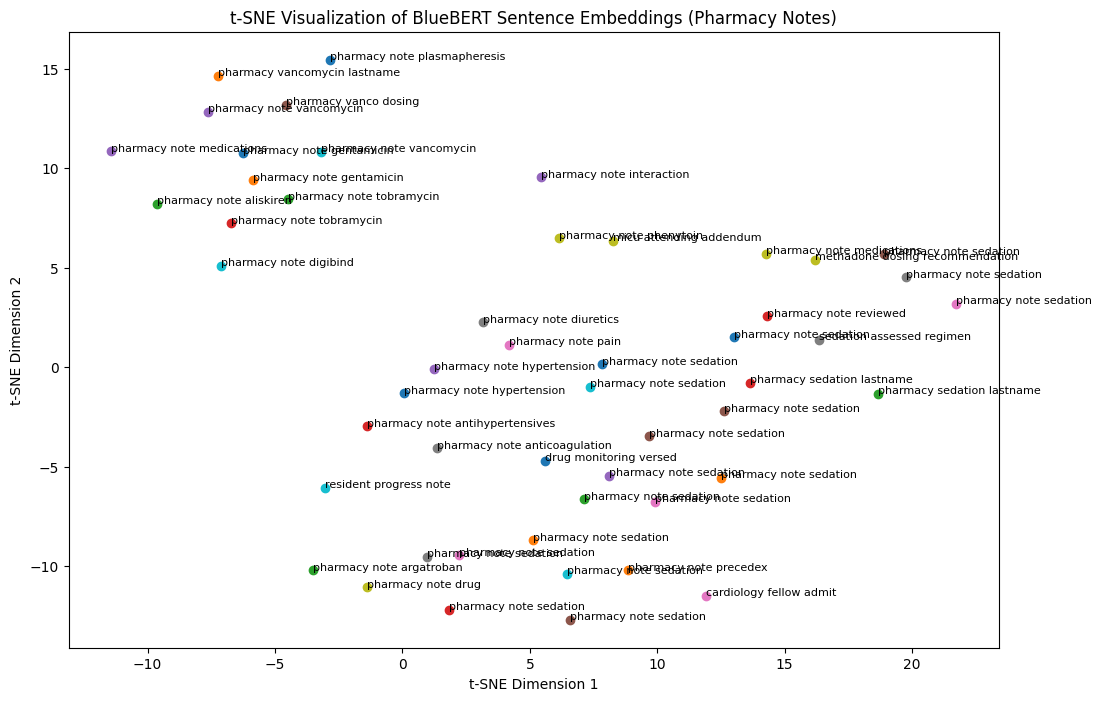

In [21]:
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import AutoModel, AutoTokenizer

# Ensure model is in evaluation mode
blue_bert_model.eval()

# Store embeddings & words for visualization
sentence_embeddings = []
word_labels = []

# Process each pharmacy note
for i, text in enumerate(pharmacy_texts):
    input_text = clean_text(text)  # Apply preprocessing

    # Skip empty texts after cleaning
    if not input_text.strip():
        print(f"Skipping empty note at index {i}")
        continue

    # Tokenize the text
    inputs = blue_tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)

    # Get BERT embeddings
    with torch.no_grad():
        outputs = blue_bert_model(**inputs)

    # Extract sentence embedding (mean of last hidden state)
    sentence_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    # Store the embedding
    sentence_embeddings.append(sentence_emb)

    # Store the first few words as labels for visualization
    word_labels.append(input_text.split()[:3])  # Use first 3 words as label

# Convert embeddings to NumPy array
sentence_embeddings = np.array(sentence_embeddings)

# Ensure embeddings exist before t-SNE
if sentence_embeddings.shape[0] == 0:
    print("No valid embeddings found. Exiting.")
else:
    # Perform t-SNE dimensionality reduction
    tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
    embeddings_2d = tsne_model.fit_transform(sentence_embeddings)

    # Create a scatter plot of the word embeddings in 2D space
    plt.figure(figsize=(12, 8))
    for i in range(len(embeddings_2d)):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
        plt.annotate(" ".join(word_labels[i]), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

    plt.title("t-SNE Visualization of BlueBERT Sentence Embeddings (Pharmacy Notes)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

In [23]:
!pip install scispacy
!pip install spacy==3.5.3
!pip install scispacy==0.5.1
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz
!pip install gensim
!pip install tqdm
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

  Using cached spacy-3.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached thinc-8.1.12-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
Using cached spacy-3.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
Using cached thinc-8.1.12-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (917 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.5
    Uninstalling thinc-8.2.5:
      Successfully uninstalled thinc-8.2.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-ner-bc5cdr-md 0.5.1 requires spacy<3.5.0,>=3.4.1, but you have spacy 3.5.3 which is incompatible.
en-core-sci-md 0.5.1 requires spac

In [ ]:
import spacy
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
!python -m spacy download en_core_web_md

Extracted 42 SpaCy entity lists and 51 SciSpaCy entity lists.
Word2Vec models trained separately for SpaCy and SciSpaCy.


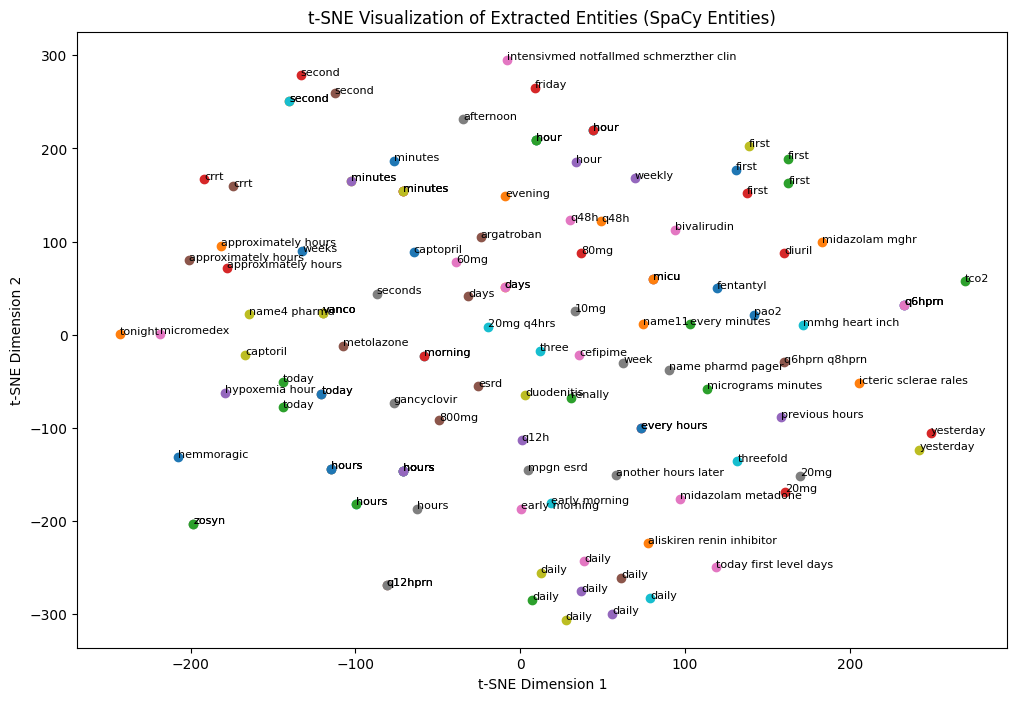

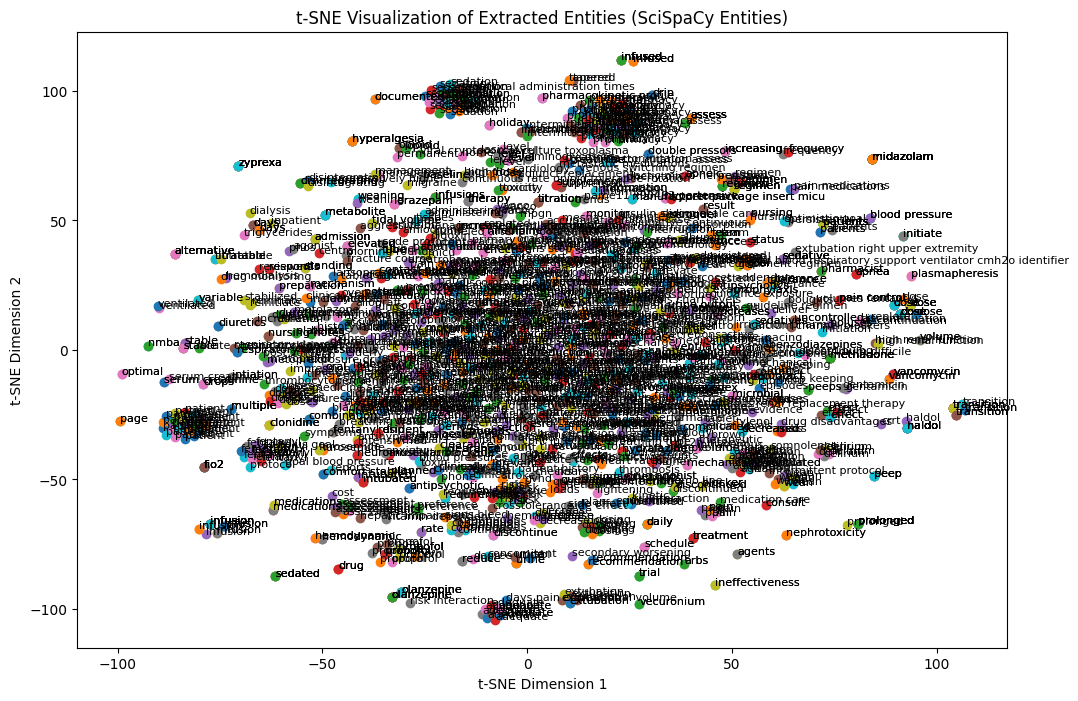

In [30]:
nlp_spacy = spacy.load("en_core_web_md")  # General NLP model
nlp_scispacy = spacy.load("en_core_sci_md")  # Clinical NLP model

# Step 1: Extract Entities Separately for SpaCy & SciSpaCy
corpus_spacy, corpus_scispacy = [], []

for text in pharmacy_texts:
    cleaned_text = clean_text(text)  # Apply text cleaning
    if not cleaned_text.strip():
        continue  # Skip empty notes

    # Extract entities using SpaCy
    doc_spacy = nlp_spacy(cleaned_text)
    spacy_entities = [ent.text for ent in doc_spacy.ents]

    # Extract entities using SciSpaCy
    doc_scispacy = nlp_scispacy(cleaned_text)
    scispacy_entities = [ent.text for ent in doc_scispacy.ents]

    if spacy_entities:
        corpus_spacy.append(spacy_entities)
    if scispacy_entities:
        corpus_scispacy.append(scispacy_entities)

print(f"Extracted {len(corpus_spacy)} SpaCy entity lists and {len(corpus_scispacy)} SciSpaCy entity lists.")

# Step 2: Train Word2Vec Model Separately for Both
w2v_spacy = Word2Vec(sentences=corpus_spacy, vector_size=100, window=5, min_count=1, workers=4)
w2v_scispacy = Word2Vec(sentences=corpus_scispacy, vector_size=100, window=5, min_count=1, workers=4)
print("Word2Vec models trained separately for SpaCy and SciSpaCy.")

# Step 3: Define Function to Plot Entities Separately
def plot_tsne(entity_list, w2v_model, title):
    """Plots a t-SNE visualization for a specific entity category."""
    entity_embeddings = []
    entity_labels = []

    for entity in entity_list:
        if entity in w2v_model.wv:
            entity_embeddings.append(w2v_model.wv[entity])
            entity_labels.append(entity)

    entity_embeddings = np.array(entity_embeddings)

    if entity_embeddings.shape[0] == 0:
        print(f"⚠ No valid embeddings found for {title}. Skipping plot.")
        return

    tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne_model.fit_transform(entity_embeddings)

    # Create scatter plot
    plt.figure(figsize=(12, 8))
    for i in range(len(reduced_embeddings)):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.annotate(entity_labels[i], (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8)

    plt.title(f"t-SNE Visualization of Extracted Entities ({title})")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Step 4: Generate Separate Plots for SpaCy & SciSpaCy
all_spacy_entities = [ent for sublist in corpus_spacy for ent in sublist]
all_scispacy_entities = [ent for sublist in corpus_scispacy for ent in sublist]

plot_tsne(all_spacy_entities, w2v_spacy, "SpaCy Entities")
plot_tsne(all_scispacy_entities, w2v_scispacy, "SciSpaCy Entities")
